# 对极几何

### 目标

在本节中
- 我们将学习多视图几何的基础知识
- 我们将了解什么是极点，极线，极线约束等。

### 基础概念
当我们使用针孔相机拍摄图像时，我们失去了重要信息，即图像深度。 或者图像中的每个点距相机多远，因为它是3D到2D转换。 因此，是否能够使用这些摄像机找到深度信息是一个重要的问题。 答案是使用不止一台摄像机。 在使用两台摄像机（两只眼睛）的情况下，我们的眼睛工作方式相似，这称为立体视觉。 因此，让我们看看OpenCV在此字段中提供了什么。

（Gary Bradsky 的 Learning OpenCV 在该领域有很多信息。）

在深入图像之前，让我们首先了解多视图几何中的一些基本概念。在本节中，我们将讨论对极几何。请参见下图，该图显示了使用两台摄像机拍摄同一场景的图像的基本设置。

[](data/epipolar.jpg)

如果仅使用左摄像机，则无法找到与图像中的点相对应的3D点，因为线上的每个点都投影到图像平面上的同一点。但也要考虑正确的形象。现在，直线$OX$上的不同点投射到右侧平面上的不同点($x'$)。因此，使用这两个图像，我们可以对正确的3D点进行三角剖分。这就是整个想法。

不同点的投影在右平面$OX$上形成一条线(line$l'$)。我们称其为对应于该点的**Epiline**。这意味着，要在正确的图像上找到该点，请沿着该轮廓线搜索。它应该在这条线上的某处（以这种方式考虑，可以在其他图像中找到匹配点，而无需搜索整个图像，只需沿着Epiline搜索即可。因此，它可以提供更好的性能和准确性）。这称为对极约束。类似地，所有点在另一幅图像中将具有其对应的Epiline。该平面称为**对极面**。

$O$和$O'$是相机中心。从上面给出的设置中，您可以看到在点处的左侧图像上可以看到右侧摄像机$O'$的投影。它称为**极点**。极点是穿过相机中心和图像平面的线的交点。左摄像机的极点也同理。在某些情况下，您将无法在图像中找到极点，它们可能位于图像外部（这意味着一个摄像机看不到另一个摄像机）。

所有的极线都通过其极点。因此，要找到中心线的位置，我们可以找到许多中心线并找到它们的交点。

因此，在节中，我们将重点放在寻找对极线和极线。但是要找到它们，我们需要另外两种成分，即**基础矩阵(F)**和**基本矩阵(E)**，基础矩阵包含有关平移和旋转的信息，这些信息在全局坐标中描述了第二个摄像头相对于第一个摄像头的位置。参见下图(图像由Gary Bradsky提供：Learning OpenCV): 

![](data/essential_matrix.jpg)

但是我们会更喜欢在像素坐标中进行测量，对吧？ 基本矩阵除包含有关两个摄像头的内在信息之外，还包含与基本矩阵相同的信息，因此我们可以将两个摄像头的像素坐标关联起来。（如果我们使用的是校正后的图像，并用焦距除以标准化该点，$F=E$）。简而言之，基本矩阵F将一个图像中的点映射到另一图像中的线（上）。这是从两个图像的匹配点计算得出的。 至少需要8个这样的点才能找到基本矩阵（使用8点算法时）。 选择更多点并使用RANSAC将获得更可靠的结果。

### 代码
因此，首先我们需要在两个图像之间找到尽可能多的匹配项，以找到基本矩阵。为此，我们将SIFT描述符与基于FLANN的匹配器和比率测试结合使用。

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img1 = cv.imread('data/bookleft.jpg',0)  #索引图像 # left image
img2 = cv.imread('data/bookright.jpg',0) #训练图像 # right image

sift = cv.SIFT_create()

# 使用SIFT查找关键点和描述符
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN 参数
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# 根据Lowe的论文进行比率测试
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

现在，我们获得了两张图片的最佳匹配列表。 让我们找到基本面矩阵。

In [2]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

# 我们只选择内点
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

接下来，我们找到Epilines。在第二张图像上绘制与第一张图像中的点相对应的Epilines。因此，在这里提到正确的图像很重要。我们得到了一行线。因此，我们定义了一个新功能来在图像上绘制这些线条。

In [3]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - 我们在img2相应位置绘制极点生成的图像
        lines - 对应的极点 '''
    r,c = img1.shape

    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)

    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())

        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])

        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)

    return img1,img2

现在，我们在两个图像中都找到了Epiline并将其绘制。

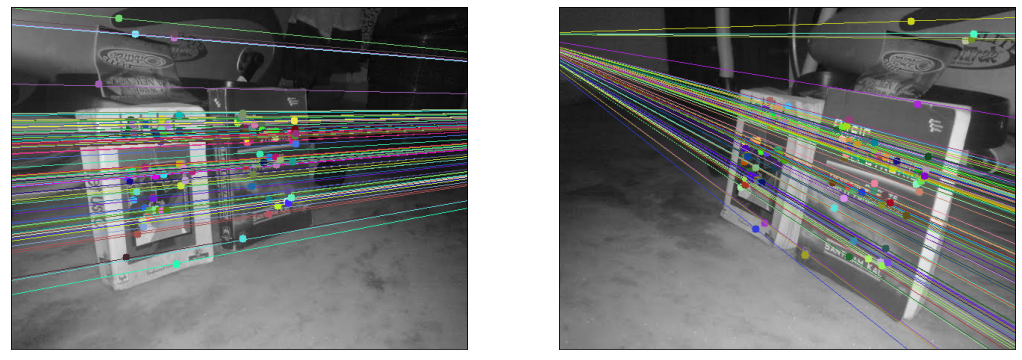

In [5]:
# 在右图（第二张图）中找到与点相对应的极点，然后在左图绘制极线
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# 在左图（第一张图）中找到与点相对应的Epilines，然后在正确的图像上绘制极线
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)

img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(18,8))
plt.subplot(121),plt.imshow(img5)
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img3)
plt.xticks([]), plt.yticks([])

plt.show()

您可以在左侧图像中看到所有极点都收敛在右侧图像的外部。那个汇合点就是极点。
为了获得更好的结果，应使用具有良好分辨率和许多非平面点的图像。

### 附加资源

### 练习
1. 一个重要的主题是相机的前移。然后，将在两个位置的相同位置看到极点，并且从固定点出现极点。 请参阅此讨论。
2. 基本矩阵估计对匹配，离群值等的质量敏感。如果所有选定的匹配都位于同一平面上，则情况会变得更糟。检查此讨论。